In [49]:
# 04_results_analysis.ipynb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plotting defaults
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 120

In [52]:
# --- Load PPO and Random results saved from 03 ---
import pickle

# After running 03, save the pnl results like this:
# with open("ppo_random_pnls.pkl", "wb") as f:
#     pickle.dump({"ppo": ppo_pnls, "random": random_pnls}, f)

with open("../notebooks/ppo_random_pnls.pkl", "rb") as f:
    pnl_data = pickle.load(f)

ppo_pnls = pnl_data["ppo"]
random_pnls = pnl_data["random"]

# Convert to DataFrames for analysis
ppo_df = pd.DataFrame(ppo_pnls).T
random_df = pd.DataFrame(random_pnls).T

print("PPO shape:", ppo_df.shape)
print("Random shape:", random_df.shape)

PPO shape: (63, 5)
Random shape: (63, 5)


In [53]:
def hedging_error_variance(pnl: pd.Series) -> float:
    """
    Compute the sample variance of the hedging P&L series.
    """
    pnl_clean = pnl.dropna()
    if pnl_clean.empty:
        return np.nan
    return float(pnl_clean.var(ddof=1))

In [54]:
def value_at_risk(pnl: pd.Series, alpha: float = 0.99) -> float:
    """
    Compute Value-at-Risk (VaR) at the given confidence level.

    Convention: P&L-based — the VaR is the lower-tail quantile of the
    P&L distribution at probability 1 - alpha. Negative values indicate
    potential losses.
    """
    pnl_clean = pnl.dropna()
    if pnl_clean.empty:
        return np.nan
    return float(pnl_clean.quantile(1 - alpha))

In [55]:
def conditional_var(pnl: pd.Series, alpha: float = 0.95) -> float:
    """
    Compute Conditional Value-at-Risk (CVaR), also called expected shortfall.

    CVaR is the mean of P&L outcomes at or below the VaR threshold
    for the chosen confidence level. Negative values indicate losses.
    """
    pnl_clean = pnl.dropna()
    if pnl_clean.empty:
        return np.nan
    var_threshold = pnl_clean.quantile(1 - alpha)
    tail_losses = pnl_clean[pnl_clean <= var_threshold]
    if tail_losses.empty:
        return float(var_threshold)
    return float(tail_losses.mean())

In [56]:
def turnover(positions: pd.Series) -> float:
    """Compute total turnover as the sum of absolute position changes."""
    return float(positions.dropna().diff().abs().sum())

In [57]:
def cost_efficiency(pnl: pd.Series, costs: pd.Series) -> float:
    """
    Compute risk reduction per unit of cost.

    Risk reduction is proxied by the inverse of the hedging error variance,
    so lower hedging variance increases the score. Returns NaN when either
    the hedging variance or total costs are zero.
    """
    variance = hedging_error_variance(pnl)
    total_costs = costs.dropna().sum()
    if variance <= 0 or total_costs <= 0:
        return np.nan
    return float(1.0 / (variance * total_costs))

In [58]:
# --- Evaluate PPO vs Random with risk metrics ---
metrics = {}

for name, df in {"PPO": ppo_df, "Random": random_df}.items():
    pnl_series = df.iloc[-1].dropna()  # take final PnL distribution across episodes
    metrics[name] = {
        "Hedging Error Var": hedging_error_variance(pnl_series),
        "VaR (99%)": value_at_risk(pnl_series, alpha=0.99),
        "CVaR (95%)": conditional_var(pnl_series, alpha=0.95),
        "Sharpe": pnl_series.mean() / pnl_series.std(ddof=1),
    }

pd.DataFrame(metrics)

,PPO,Random
Hedging Error Var,0.277048,24.609525
VaR (99%),-0.477662,-8.365282
CVaR (95%),-0.500734,-8.473784
Sharpe,0.513328,-0.618876


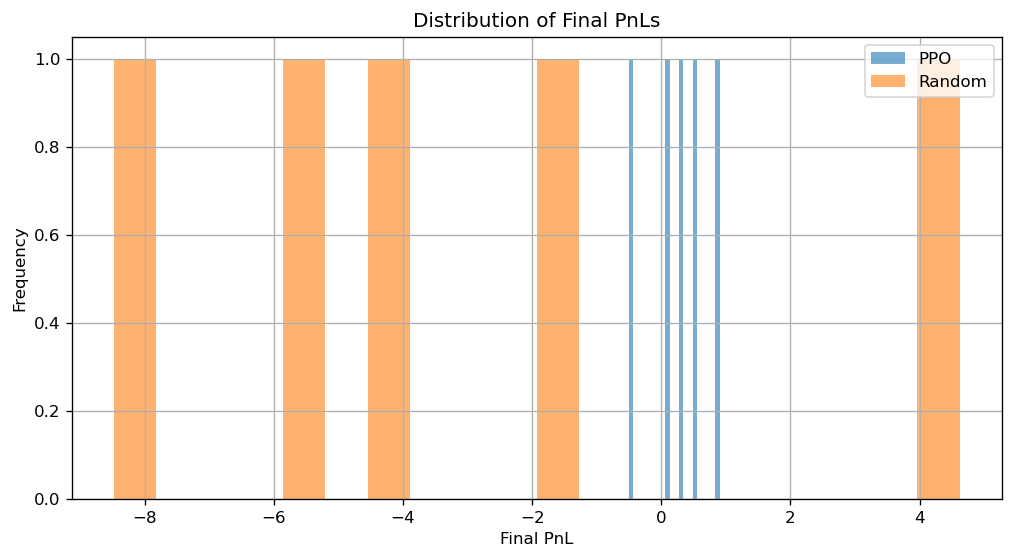

<Figure size 1200x600 with 0 Axes>

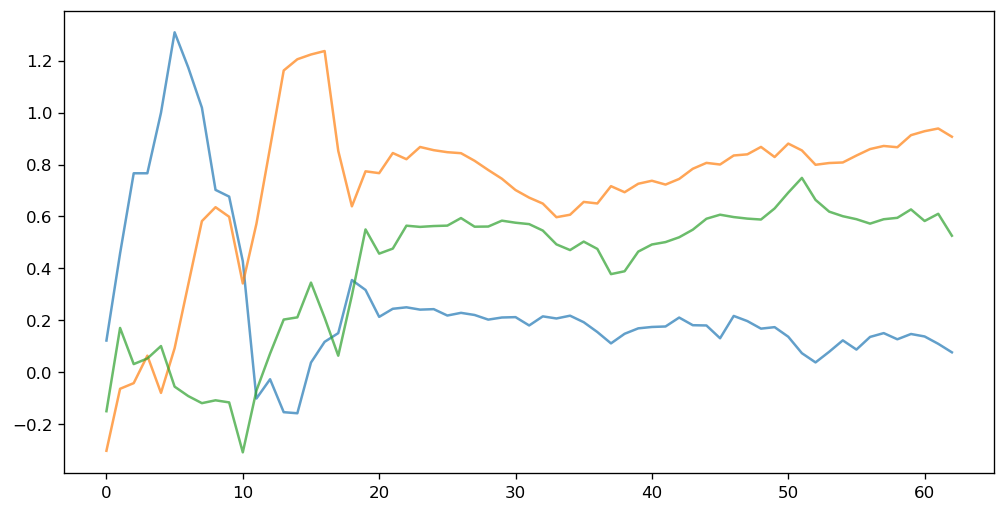

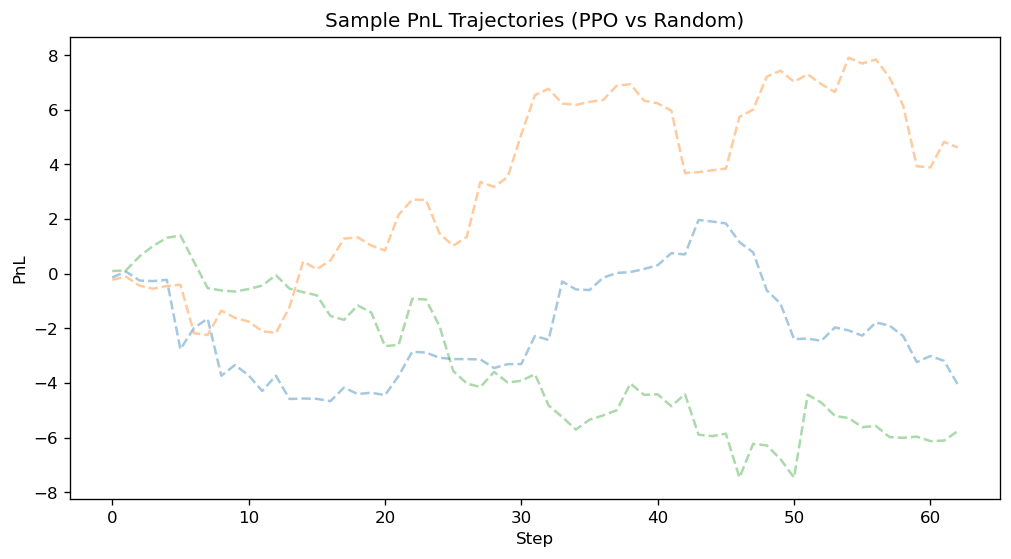

In [59]:
# Distribution of final PnLs
plt.figure(figsize=(10,5))
ppo_df.iloc[-1].dropna().hist(alpha=0.6, bins=20, label="PPO")
random_df.iloc[-1].dropna().hist(alpha=0.6, bins=20, label="Random")
plt.title("Distribution of Final PnLs")
plt.xlabel("Final PnL")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Example trajectory plot
plt.figure(figsize=(10,5))
ppo_df.iloc[:, :3].plot(legend=False, alpha=0.7)
random_df.iloc[:, :3].plot(legend=False, alpha=0.4, linestyle="--")
plt.title("Sample PnL Trajectories (PPO vs Random)")
plt.xlabel("Step")
plt.ylabel("PnL")
plt.show()

In [60]:
print(f"Hedging error variance: {hedging_error_variance(pnl_series):.6f}")
print(f"Value-at-Risk (99%): {value_at_risk(pnl_series, alpha=0.99):.6f}")
print(f"Conditional VaR (95%): {conditional_var(pnl_series, alpha=0.95):.6f}")
print(f"Turnover: {turnover(positions_series):.6f}")
print(f"Cost efficiency: {cost_efficiency(pnl_series, costs_series):.6f}") 

Hedging error variance: 24.609525
Value-at-Risk (99%): -8.365282
Conditional VaR (95%): -8.473784
Turnover: 1147.363710
Cost efficiency: 0.007455
